# 12-More Regression
Data regression is a critical skill to determine correlations and potentially causations between different variables in a system.  In this lecture, we will learn how to use Python to perform regression and interpolation.

Again, regression is used to obtain a relationship between an independent variable (or multiple independent variables) and an outcome. That relationship can then be used to make predictions. 

## Example with Vehicle Data
Your vehicle monitors many different variables including the revolutions per minute, gas mileage, oxygen sensors, and catalytic converter temperature (unless you have an electric car) to name a few. You have access to that data as there's an OBD II port likely below your steering wheel. I've collected some data from my 2019 Kia Forte that we'll look at.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# read in the data from the csv file about weather in Ogden Utah
data = pd.read_csv('supportfiles/kiadata.csv')


In [2]:
# prepare data
data['time'] = pd.to_datetime(data['time']) # set time to datetime to help with plotting
data = data.set_index('time') #set index to time

# fill in NaNs as the data for each variable is collected at different times (and so places NaNs in the other columns)
# fill in NaNs - forward fill - fill in missing values with the previous value
data.fillna(method='ffill',inplace=True)
# fill in NaNs - backward fill
data.fillna(method='bfill',inplace=True)

# remove columns that match keywords
for dc in data.columns:
    if ("Average" in dc) or ("(total)" in dc) \
       or ("$" in dc) or ("(mA)" in dc) or ('Unnamed' in dc):
        del data[dc]

/var/folders/6d/1jr2w1qx1rnd2nkndlq4hc700000gn/T/ipykernel_17163/834267956.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['time'] = pd.to_datetime(data['time']) # set time to datetime to help with plotting


In [3]:
# print data columns
for x in data.columns:
    print(x)

# warm-ups since codes cleared ()
Absolute load value (%)
Absolute pedal position D (%)
Absolute pedal position E (%)
Absolute throttle position B (%)
Actual engine - percent torque (%)
Altitude (GPS) (feet)
Ambient air temperature (℉)
Barometric pressure (kPa)
Calculated boost (bar)
Calculated engine load value (%)
Calculated instant fuel consumption (MPG)
Calculated instant fuel rate (gal./h)
Catalyst temperature Bank 1 Sensor 1 (℉)
Catalyst temperature Bank 1 Sensor 2 (℉)
Commanded EGR duty (%)
Commanded evaporative purge (%)
Commanded throttle actuator (%)
Control module voltage (V)
Distance to empty (miles)
Distance traveled since codes cleared (miles)
Distance traveled with MIL on (miles)
Distance travelled (miles)
EGR error (%)
Engine coolant temperature (℉)
Engine Exhaust Flow Rate (g/sec)
Engine Friction - Percent Torque (%)
Engine Fuel Rate (g/sec)
Engine reference torque (N⋅m)
Engine RPM (rpm)
Engine RPM x1000 (rpm)
Evap. system vapor pressure (Pa)
Fuel economizer (based on 

In [4]:
#rename columns
data.rename(columns={'Calculated instant fuel consumption (MPG)':'Calculated MPG'}, inplace=True)

In [5]:
#also reset the data for the calculated MPG to be at most 100 mpg with a lambda function
data['Calculated MPG'] = data['Calculated MPG'].apply(lambda x: 100 if x>100 else x)

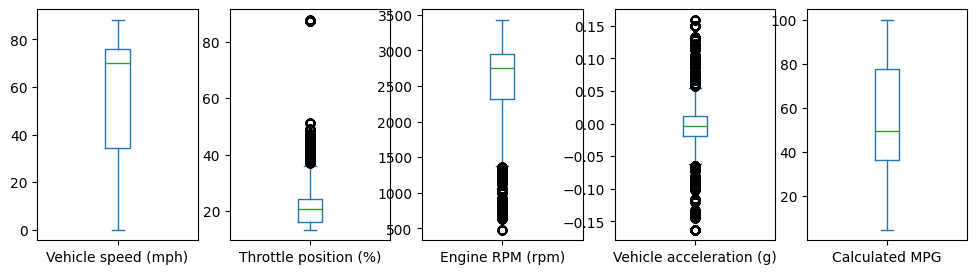

In [6]:
select = ['Vehicle speed (mph)','Throttle position (%)',\
          'Engine RPM (rpm)', 'Vehicle acceleration (g)','Calculated MPG']
data[select].plot(kind='box', subplots=True, figsize=(12,3))
plt.show()

### Pair plot
A pair plot can be helpful to see if any of the variables appear related

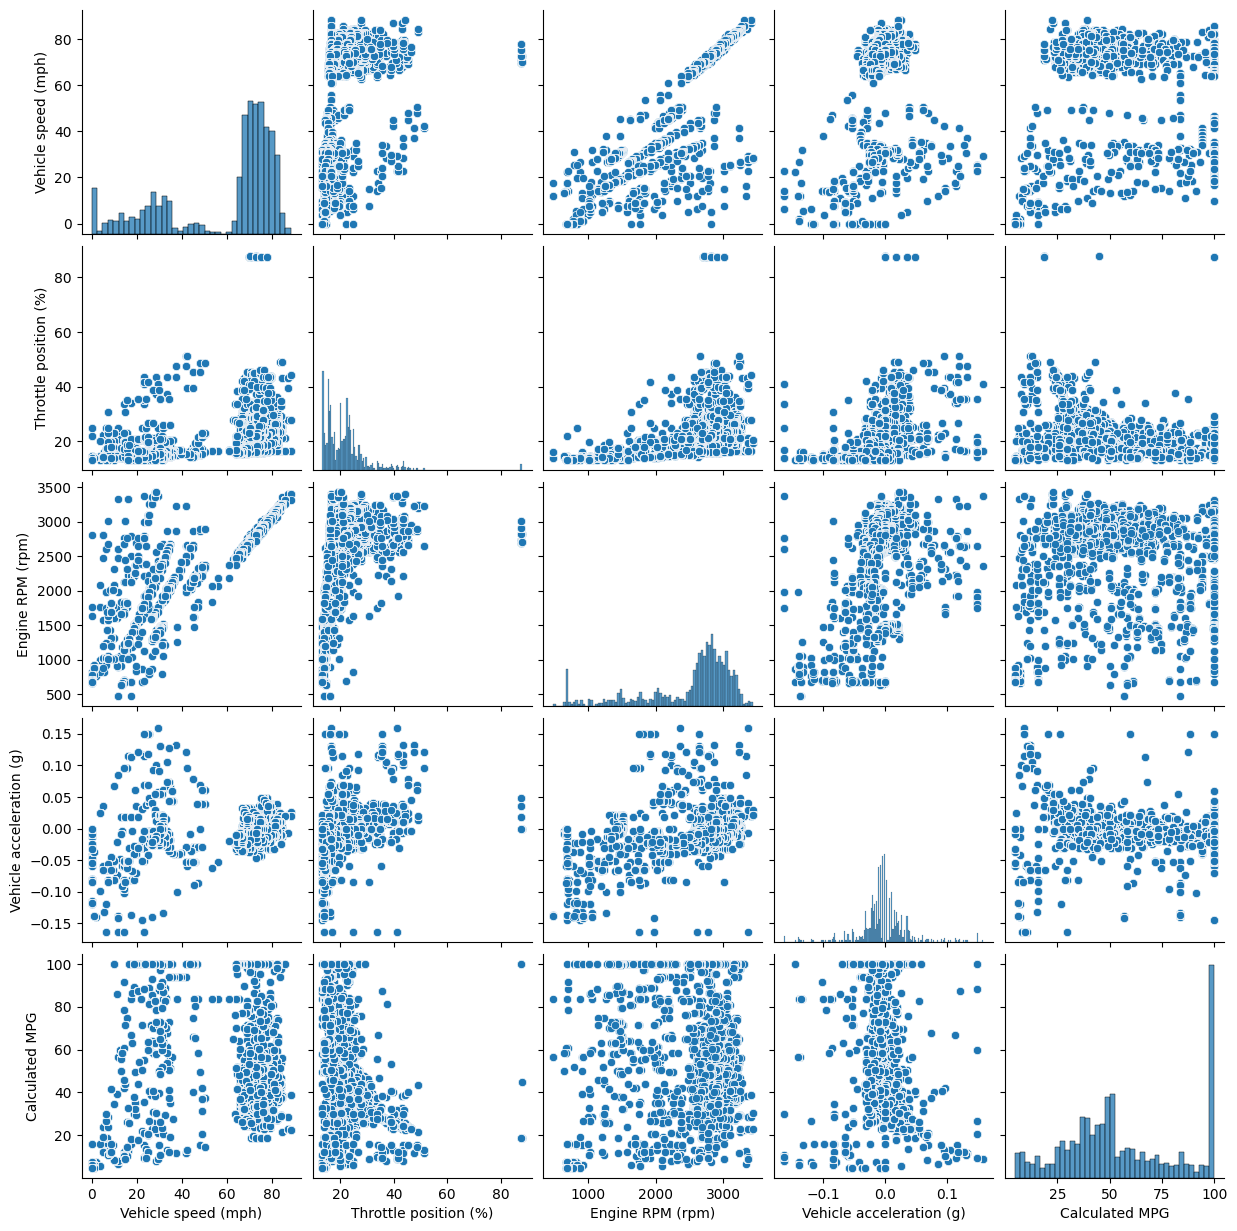

In [7]:
import seaborn as sns
sns.pairplot(data[select])
plt.show()

From the above description, there are many variables that could be related to each other. For example, the revolutions per minute (RPM) could be related to the gas mileage. The catalytic converter temperature could be related to the oxygen sensor. We'll look at the relationship between the RPM and gas mileage.

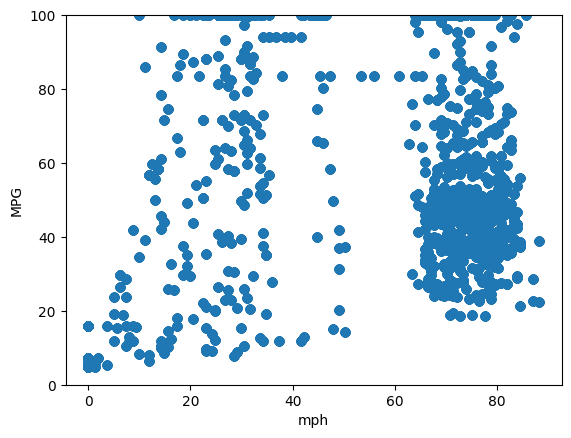

In [8]:
#plot the mph vs. gas mileage
plt.scatter(data['Vehicle speed (mph)'],data['Calculated MPG'])
plt.ylim(0,100);
plt.xlabel('mph');plt.ylabel('MPG')
plt.show()


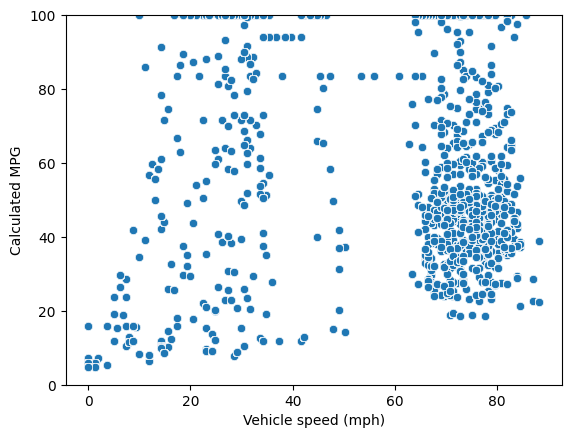

In [9]:
#alternatively plot the above plot in seaborn
sns.scatterplot(x='Vehicle speed (mph)',y='Calculated MPG',data=data)
plt.ylim(0,100);
plt.show()

### Linear Regression

It looks like there might be a relationship between the speed and miles per gallon. However, there is some conditions we could filter from the data such as when the throttle position is low (we may be coasting and thus have a high gas mileage). 

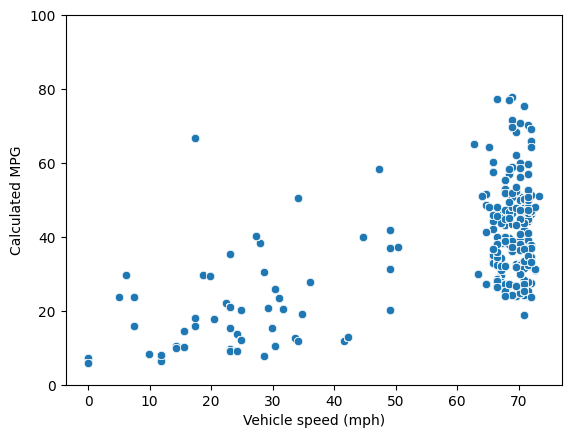

In [10]:
#Filter the calculated mpg to include only when the throttle position is greater than a given value 
# (to eliminate coasting) and 
# when the rpms are less than a given value as it's a manual and I should have shifted gears
# and when the Calculated MPG is less than 80 (also coasting)
data2 = data[(data['Throttle position (%)']>20) & (data['Engine RPM (rpm)']<2800) & \
             (data['Calculated MPG']<80)]
sns.scatterplot(x='Vehicle speed (mph)',y='Calculated MPG',data=data2)
plt.ylim(0,100);
plt.show()

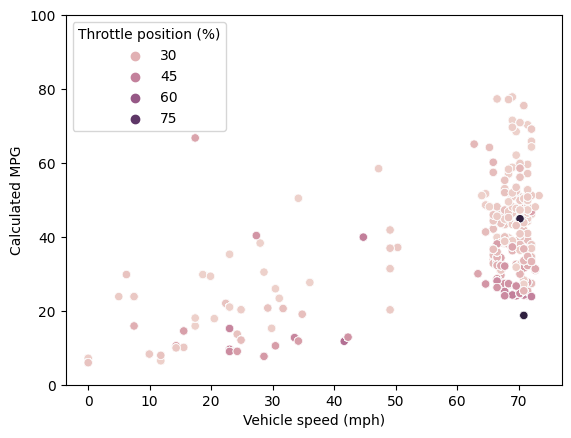

In [11]:
# we can also color the points by the throttle position
sns.scatterplot(x='Vehicle speed (mph)',y='Calculated MPG',hue='Throttle position (%)' ,data=data2)
plt.ylim(0,100);
plt.show()

#### Linear Regression with Scipy Curve_fit

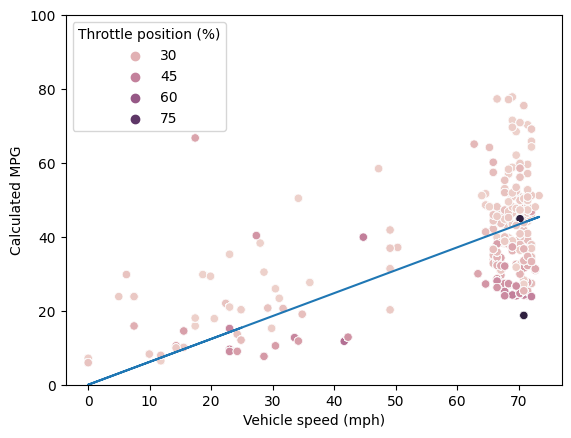

In [12]:
#Most of the data is at around 70 miles an hour and 30% throttle position but we'll still fit a line to the data.
#We'll use the scipy package to fit a line to the data with the intercept forced to be 0
from scipy.optimize import curve_fit

# define the function to fit
def linear(x, a):
    return a*x

# fit the function to the data
popt, pcov = curve_fit(linear, data2['Vehicle speed (mph)'],data2['Calculated MPG'])
#Plot the line on top of the data
sns.scatterplot(x='Vehicle speed (mph)',y='Calculated MPG',hue='Throttle position (%)' ,data=data2)
plt.ylim(0,100);
plt.plot(data2['Vehicle speed (mph)'],linear(data2['Vehicle speed (mph)'],*popt))
plt.show()

In [13]:
#slope is
print(f'slope is {popt[0]:0.4f}')

slope is 0.6195


In [14]:
# determine the coefficient of determination, R^2
import numpy as np
def R2(y, yhat):
    return 1 - np.sum((y - yhat)**2)/np.sum((y - np.mean(y))**2)

Rsq = R2(data2['Calculated MPG'], linear(data2['Vehicle speed (mph)'],*popt))
print(f'R^2 =  {Rsq:0.4f}')

R^2 =  0.2842


What comments do you have on the above regression and plot? What does the literature say on what speed is best for gas mileage? What happens to the force from drag as you increase speed?

#### Linear Regression with Statsmodels

In [15]:
#Complete the same above task with the statsmodels package
import statsmodels.api as sm
X = data2['Vehicle speed (mph)']
y = data2['Calculated MPG']
#X = sm.add_constant(X) include this if you want to fit a line with an intercept
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         Calculated MPG   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                          7.678e+04
Date:                Thu, 14 Sep 2023   Prob (F-statistic):                        0.00
Time:                        07:27:50   Log-Likelihood:                         -33146.
No. Observations:                8324   AIC:                                  6.629e+04
Df Residuals:                    8323   BIC:                                  6.630e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Note that the way these R-squared values are calculated is inaccurate without an intercept (0.28 vs. 0.90).

### Multivariable regression
What if, instead of one parameter, we used two or three parameters. For example, lets say we wanted to predict the gas mileage based on the speed and the throttle position. We can do that with multivariable regression.

#### Linear Algebra Review
Linear algebra is used here and elsewhere in the course.  Here's a quick review of the basics.

**Vectors**<br>
A vector is a list of numbers.  For example, the vector $\vec{a}$ is defined as:

$$\vec{a} = \begin{bmatrix} 2.1 \\ 2.4 \\ 2.2 \end{bmatrix}$$

**Matrices**<br>
A matrix can be a 2D array of numbers.  For example, the matrix $X$ is defined as:

$$X = \begin{bmatrix} 1.2 & 1.3 & 1.4 & 1.2 & 1.3\\ 4.1 & 5.2 & 5.1 & 5.2 & 5.0 \\ 7.8 & 8.1 & 8.2 & 8 & 7.7\end{bmatrix}$$

**Dot Product**<br>
The dot product of the vector $\vec{a}$ and matrix $X$ is defined as:

$$\vec{a} \cdot X  = \begin{bmatrix} 2.1 \cdot 1.2 + 2.4 \cdot 4.1 + 2.2 \cdot 7.8 \\ 2.1 \cdot 1.3 + 2.4 \cdot 5.2 + 2.2 \cdot 8.1\\ 2.1 \cdot 1.4 + 2.4 \cdot 5.1 + 2.2 \cdot 8.2 \\ ... + ... + ... \\ ... + ... + ... \end{bmatrix} $$






**Dot Product Example**

In [16]:
matrix = np.array([data2['Vehicle speed (mph)'],data2['Throttle position (%)']])
matrix.shape

(2, 8324)

In [17]:
scalars = np.array([1.2,1.3])
scalars.shape

(2,)

In [18]:
dotprod = np.dot(scalars,matrix)
dotprod.shape

(8324,)

In [19]:
matrix[0][5443], matrix[1][5443], dotprod[5443], matrix[0][5443]*scalars[0] + matrix[1][5443]*scalars[1]

(66.4867175693947, 27.0588235294118, 114.96053167150899, 114.96053167150899)

#### Multivariable Regression with Scipy minimize

In [20]:
def multilinear(a):
    a = np.array(a)
    scalar = np.ones(len(data2))
    x = np.array([scalar,data2['Vehicle speed (mph)'],data2['Throttle position (%)']])
    return np.sum((data2['Calculated MPG']- (np.dot(a,x)))**2) #x and a are arrays

In [21]:
#we'll use the scipy minimize function to fit the data
from scipy.optimize import minimize

# provide a guess for the coefficients
coeff0 = [0.1,0.1,0.1]
# now minimize the function
res = minimize(multilinear, coeff0)

In [22]:
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1087849.987787568
        x: [ 2.925e+01  4.599e-01 -6.773e-01]
      nit: 5
      jac: [ 0.000e+00  6.250e-02  3.125e-02]
 hess_inv: [[ 1.957e-06  1.750e-07 -4.935e-07]
            [ 1.750e-07  8.946e-08 -1.864e-07]
            [-4.935e-07 -1.864e-07  4.676e-07]]
     nfev: 56
     njev: 14

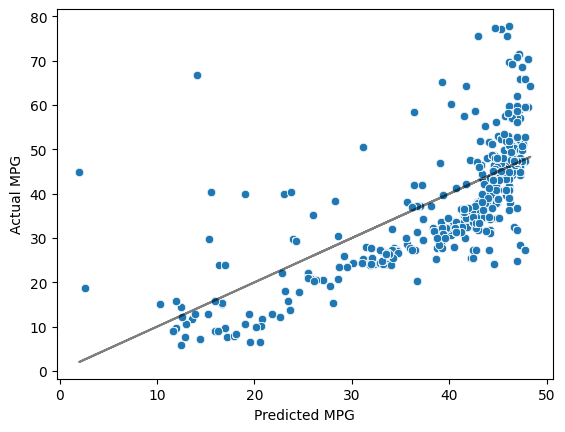

In [23]:
#now plot the predicted values versus the actual values
predicted = np.dot(res.x,np.array([np.ones(len(data2)),data2['Vehicle speed (mph)'],data2['Throttle position (%)']]))
sns.scatterplot(x=predicted,y=data2['Calculated MPG'])
plt.plot(predicted,predicted,'k',alpha=0.5)
plt.xlabel('Predicted MPG');plt.ylabel('Actual MPG')
plt.show()

In [24]:
#determine the R^2 value
Rsq = R2(data2['Calculated MPG'], predicted)
print(f'R^2 =  {Rsq:0.4f}')

R^2 =  0.4443


In [25]:
#aso calculate the mean absolute percentage error
def MAPE(y, yhat):
    return np.mean(np.abs((y - yhat)/y))*100

MAPE(data2['Calculated MPG'], predicted)

26.10792187471055

Thus, on average, the prediction is 26% off from the actual value.  This is not a great model.  It could be improved by adding more variables like the engine rpms. However, the prediction isn't bad as many heat transfer empirical correlations can also be off by 25%.

In [26]:
res.x

array([29.24850767,  0.45987639, -0.67728963])

The coefficients show that the gas mileage is positively correlated to the vehicle speed and negatively correlated to the throttle position.  Does this make sense?

In [27]:
#now complete the multiple linear regression with the statsmodels package
X = data2[['Vehicle speed (mph)','Throttle position (%)']]
y = data2['Calculated MPG']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Calculated MPG   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     3327.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        07:27:50   Log-Likelihood:                -32092.
No. Observations:                8324   AIC:                         6.419e+04
Df Residuals:                    8321   BIC:                         6.421e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    29.24